# Setup

In [44]:
# # Init pyspark
# from pyspark import SparkContext
# sc = SparkContext.getOrCreate()
# # Init sparksql -- Only used to format the output nicely!
# from pyspark.sql import SQLContext
# sqlContext = SQLContext(sc)

# rows = sc.textFile("/air_transit_2007.csv")
# #rows = sc.textFile("/Users/abel/Downloads/spare_time/working/a13544_600_spark/air_transit_2007.csv")

# data = rows.map(lambda line: line.split(","))
# # data.cache()

# import findspark
# findspark.init()
# A simple demo for working with SparkSQL and Tweets
from pyspark import SparkContext, SparkConf
from pyspark.sql import HiveContext, Row
from pyspark.sql.types import IntegerType
import json
import sys


inputFile = 'air_transit_2007.csv'
inputFile = '/home/abel/AbelProject/DataAnalysis/a15541spark/air_transit_2007.csv'

conf = SparkConf().setAppName("SparkSQLAirTransit")
SparkConf().set("spark.sql.legacy.timeParserPolicy","LEGACY")

sc = SparkContext.getOrCreate(conf=conf)
hiveCtx = HiveContext(sc)
print("Loading tweets from " + inputFile)


Loading tweets from /home/abel/AbelProject/DataAnalysis/a15541spark/air_transit_2007.csv


In [45]:
input = hiveCtx.read.option("header",True).csv(inputFile,inferSchema =True)
input.printSchema()



root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- 

In [46]:
# Sample Query

In [47]:

input.registerTempTable("air_transit")

myair_transits = hiveCtx.sql("SELECT * FROM air_transit  LIMIT 3")
print('myair_transits:' )
for item in myair_transits.collect():
    print(item, '\n')

myair_transits:
Row(Year=2007, Month=1, DayofMonth=1, DayOfWeek=1, DepTime='1232', CRSDepTime=1225, ArrTime='1341', CRSArrTime=1340, UniqueCarrier='WN', FlightNum=2891, TailNum='N351', ActualElapsedTime='69', CRSElapsedTime=75, AirTime='54', ArrDelay='1', DepDelay='7', Origin='SMF', Dest='ONT', Distance=389, TaxiIn=4, TaxiOut=11, Cancelled=0, CancellationCode=None, Diverted=0, CarrierDelay=0, WeatherDelay=0, NASDelay=0, SecurityDelay=0, LateAircraftDelay=0) 

Row(Year=2007, Month=1, DayofMonth=1, DayOfWeek=1, DepTime='1918', CRSDepTime=1905, ArrTime='2043', CRSArrTime=2035, UniqueCarrier='WN', FlightNum=462, TailNum='N370', ActualElapsedTime='85', CRSElapsedTime=90, AirTime='74', ArrDelay='8', DepDelay='13', Origin='SMF', Dest='PDX', Distance=479, TaxiIn=5, TaxiOut=6, Cancelled=0, CancellationCode=None, Diverted=0, CarrierDelay=0, WeatherDelay=0, NASDelay=0, SecurityDelay=0, LateAircraftDelay=0) 

Row(Year=2007, Month=1, DayofMonth=1, DayOfWeek=1, DepTime='2206', CRSDepTime=2130, ArrTi

## explore1
Compute the total number of records.

In [48]:
# Response...
df = input

# mycount = hiveCtx.sql("SELECT count(*) as mycount FROM air_transit")
# print('mycount=', mycount.collect()[0]['mycount'] )

print('total number of records.',df.count() )

total number of records. 8326


In [49]:

#Find total number of operated flights per month, sorted by the month..


# mymonth = hiveCtx.sql("select Month, count(*) as flight_number from air_transit group by Month order by Month LIMIT 100")
# print('total number of operated flights per month:')  
# for item in mymonth.collect():
#     print(item['Month'], 'month', item['flight_number'])
    
from pyspark.sql.functions import col

print('Explore2 total number of operated flights per month, sorted by the month:')

df1 = df.groupBy("Month").count().sort('Month',ascending=True)
names = []
values = []
for item in df1.rdd.collect():
    print(item['Month'], item['count'])
    if item['Month'] is not None:
        names.append(item['Month'])
        values.append(item['count'])


Explore2 total number of operated flights per month, sorted by the month:
None 10
1 1100
2 2739
12 4477


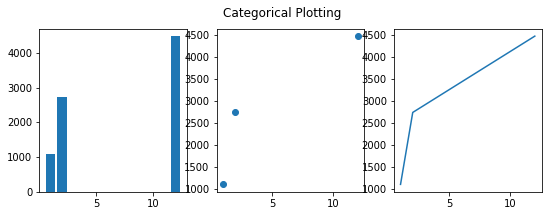

In [50]:
import matplotlib.pyplot as plt
# names = ['group_a', 'group_b', 'group_c']
# values = [1, 10, 100]

plt.figure(figsize=(9, 3))

plt.subplot(131)
plt.bar(names, values)
plt.subplot(132)
plt.scatter(names, values)
plt.subplot(133)
plt.plot(names, values)
plt.suptitle('Categorical Plotting')
plt.show()

In [51]:

# Find the plane with the highest number of flights. Each plane has a unique TailNum

print('Explore3: highest number of flights. Each plane has a unique TailNum')
df1 = df.filter(~col('TailNum').isin(['0', '000000']))
df1 = df1.groupBy("TailNum").count().sort('count',ascending=False)

if df1 is not None:
    for item in df1.rdd.collect()[:3]:
        print(item['TailNum'], item['count'])
    print('highest_number_filghts: ', df1.collect()[0]['TailNum'] )


Explore3: highest number of flights. Each plane has a unique TailNum
N912DE 99
N909DE 88
N911DE 88
highest_number_filghts:  N912DE


In [52]:
import pyspark.sql.functions as F 
from pyspark.sql.functions import count, avg
from pyspark.sql.functions import  max as max_
# Compute the total flight time of each airplane, sorted by flight time in descending order.
# total_flight_times = hiveCtx.sql("SELECT TailNum, SUM (AirTime) as total_fight_time FROM air_transit GROUP BY TailNum order by total_fight_time desc LIMIT 100")
# print('-'*10, 'We make ', '-'*10)
# print('total flight time of each airplane: ')
# for item in  total_flight_times.collect():
#     print(item['TailNum'], ' total fight time is', item['total_fight_time'])

print('Q4:total flight time of each airplane, sorted by flight time in descending order')
df1 = df.groupBy("TailNum").agg(F.sum(df['AirTime']).alias('result')).orderBy('result',ascending=False)
if df1 is not None:
    for item in df1.rdd.collect()[:3]:
        print(item['TailNum'], item['result'])

Q4:total flight time of each airplane, sorted by flight time in descending order
N3767 9977.0
N385DN 8844.0
N6707A 8173.0


In [53]:
#  Find the busiest airport (in terms of number of departures + arrivals of all operated flights) for each month.
from pyspark.sql.functions import col
import operator
df = input

for month in range(1, 3):
    print(month, '-'*10)
    df1=df.filter(col('Month').isin([month])).groupBy('Origin').count()
    df2=df.filter(col('Month').isin([month])).groupBy('Dest').count()
    #print(type(df1), type(df2))
    k_v = {}
    for orgin in df1.collect():
#         print(orgin['Origin'],orgin['cou4t'])
        k_v[orgin['Origin']] = orgin['count']
    for dest in df2.collect():
        if k_v.get(dest['Dest']) :
#             print(dest)
#             print('before',k_v[dest['Dest']])
            k_v[dest['Dest']] += dest['count']
#             print('after',k_v[dest['Dest']])

    print(k_v)
    if k_v is not None and len(k_v.items()) > 0:
        month_max, thecount = max(k_v.items(), key=operator.itemgetter(1))
        print('month_max:', month_max, ' ,departures + arrivals of this month:', thecount)



1 ----------
{'SNA': 473, 'SMF': 473, 'STL': 308}
month_max: SNA  ,departures + arrivals of this month: 473
2 ----------
{'LAS': 1771, 'LAX': 1122}
month_max: LAS  ,departures + arrivals of this month: 1771


In [54]:

# 6nd the airline with highest average delay of each type in March 2007. 
#Note: do not write separate code for each error type. 
# You should compute a single RDD where each row contains the delay type, 
# the airline that is worst regarding that delay type, and its average delay of that type in minutes.

import pyspark.sql.functions as F 
from pyspark.sql.functions import count, avg
from pyspark.sql.functions import  max as max_

# d_columns =  ['CarrierDelay','WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
print('1 all of group:')
df1 = df.groupBy("FlightNum") \
    .avg('CarrierDelay','WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay')
df1.show()

r = df1.groupBy("FlightNum").agg(F.sum(df1[1]+df1[2] + df1[3] + df1[4]).alias('result')).orderBy('result',ascending=False).head(1)
print('2 the filghtnum is:', r[0].FlightNum)

print('3 the max row:')
df1.filter(col('FlightNum').isin([r[0].FlightNum])).show()

1 all of group:
+---------+-----------------+-----------------+-------------+------------------+----------------------+
|FlightNum|avg(CarrierDelay)|avg(WeatherDelay)|avg(NASDelay)|avg(SecurityDelay)|avg(LateAircraftDelay)|
+---------+-----------------+-----------------+-------------+------------------+----------------------+
|     1959|              0.0|              0.0|          0.0|               0.0|                   0.0|
|     2659|              0.0|              0.0|          0.0|               0.0|                   0.0|
|     1238|              0.0|              0.0|          0.0|               0.0|                   0.0|
|     1591|              0.0|              0.0|          0.0|               0.0|                   0.0|
|     1645|              0.0|              0.0|          0.0|               0.0|                   0.0|
|     1460|              0.0|              0.0|          0.0|               0.0|                   0.0|
|     1522|              0.0|              0.0| 

In [55]:
## explore7
# Compute median, mean, and mode of columns 12-16, 19-21 and 25-29 
# for the flights in the third week of 2007. Exclude the non-numeric values.

from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType

print('filter out week 3')
mydf = df.filter(col('DayOfWeek').isin([3])) 

print('median of [12:16]:')
df1 = mydf.select(mydf.columns[12:16])
# df1.show()

# res  = df1.select(*[F.percentile_approx(c).alias(c) for c in df1.columns])
# res.show()
for name in ('CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay'):
    df1 = df1.withColumn(name, df1[name].cast(IntegerType()))
    quantiles = df1.approxQuantile("CRSElapsedTime", [0.25, 0.5, 0.75], 0)
    print(name, ' median: ',quantiles)

df2 = mydf.select(mydf.columns[19:21])
# df2.show()
res2  = df2.select(*[F.mean(c).alias(c) for c in df2.columns])
print('mean of [19:21] :')
res2.show()

df3 = mydf.select(mydf.columns[25:29])
# df3.show()
print('mode of [25:29] :')
# [df3.groupby(i).count().orderBy("count", ascending=False).first()[0] for i in df3.columns]
for i in df3.columns:
    t = df3.groupby(i).count().orderBy("count", ascending=False).first()
    if t is not None:
        print(t)

filter out week 3
median of [12:16]:
CRSElapsedTime  median:  []
AirTime  median:  []
ArrDelay  median:  []
DepDelay  median:  []
mean of [19:21] :
+------+-------+
|TaxiIn|TaxiOut|
+------+-------+
|  null|   null|
+------+-------+

mode of [25:29] :


In [56]:

#Assume that a passenger wants to travel from Philadelphia International Airport (airport code: PHL) 
# to Los Angeles International Airport (airport code: LAX), and then go back to Philadelphia (PHL). 
# He departs PHL not earlier than 5:59 am (scheduled time), stays at least 3:01 hours in Los Angeles and then arrive at PHL not later than 11pm. Based on the "scheduled" times, find which carrier has the highest number of flights with these constraints. 
# Limit your analysis to February 2007 and use scheduled times.

from pyspark.sql.functions import col
import pyspark.sql.functions as F


df1 = df.filter(col('Month').isin([2]) & df.DepTime.isNotNull() & df.ArrTime.isNotNull() ) 
# filter datetime is too early data
df1 = df1.filter( df.DepTime > '500' ) 
# df1 = df1.where(col("DepTime").isNotNull()).collect()
# df1 = df1.where(col("ArrTime").isNotNull()).collect()

df1 = df1.filter(col('Origin').isin(['PHL', 'LAX'])).filter(col('Dest').isin(['PHL', 'LAX']))
# df1.show()

# df2 = df1.filter(col('DepTime').isin([2])) 
print('stay 3:0 hour, it means before we shoulf flight here at least before back-fight start time - 3hours')
dates = ("1970-01-01 5:59:00", "1970-01-01 20:00:00", "1970-01-01 23:00:00")
# date_from, date_to = [to_date(lit(s)).cast(TimestampType()) for s in dates]


df2 = df1.withColumn('DepTime_Date', F.to_timestamp('DepTime', 'hhmm'))
df3 = df2.withColumn('ArrTime_Date', F.to_timestamp('ArrTime', 'hhmm'))
# df2.show()

df4 = df3.where( ((col('DepTime_Date') > dates[0]) & (col('ArrTime_Date') < dates[1])) |
           (col('ArrTime_Date') < dates[2])
         )
# df4.show()
if df4 is not None:
    df5 = df4.groupBy('UniqueCarrier').count()
    k_v = {}
    for orgin in df5.rdd.collect():

        k_v[orgin['UniqueCarrier']] = orgin['count']
    print(k_v)
    if k_v is not None and len(k_v.items())>0:
        carriar_max = max(k_v.items(), key=operator.itemgetter(1))[0]
        print('max UniqueCarrier :', carriar_max)

stay 3:0 hour, it means before we shoulf flight here at least before back-fight start time - 3hours
{}


In [57]:

#Generate the `departure flights` board of the Los Angeles Airport at 12 Jan 2007 at 13:00. 
# The board should contain flights with actual departure times between 12:00 and 14:00, 
# sorted by scheduled departure time. The resulting table should at least contain scheduled departure time, 
# actual departure time (if departed), 
# airline code, and destination
df1 = df.filter(col('Month').isin([1])).filter(col('DayofMonth').isin([1]))
df1 = df1.filter( df.CRSDepTime > '500' ) 

dates = ("1970-01-01 12:00:00", "1970-01-01 14:00:00")
dates = ("1970-01-01 00:01:00", "1970-01-01 23:59:00")
# date_from, date_to = [to_date(lit(s)).cast(TimestampType()) for s in dates]

df1 = df1.withColumn(
    "CRSDepTime",
    F.when(F.col("CRSDepTime").isNull(), '0')
    .otherwise(F.col("CRSDepTime").cast("string"))
)
df2 = df1.withColumn('DepTime_Date', F.to_timestamp('CRSDepTime', 'hhmm'))

# df2.show()
# print('@'*20)

df4 = df2.where( 
    ((col('DepTime_Date') > dates[0]) & (col('DepTime_Date') < dates[1]))
         )

print('-'*10, 'departure flights(limit 100)', '-'*10)
for item in df4.rdd.collect()[:100]:
#     print(item)
    print(item['CRSArrTime'],item['DepTime'], item['FlightNum'], item['Dest'])

---------- departure flights(limit 100) ----------
1340 1232 2891 ONT
1410 1251 933 SAN
1205 1042 1554 SAN
1225 1045 1502 SEA
1300 1140 1596 SNA
1300 1233 851 LAS
1155 1035 1184 OAK
1315 1101 324 PHX
1450 1245 1684 PHX
1250 1136 2037 SJC
1220 1052 1977 SMF
1340 1215 2588 SMF
1225 959 1477 CLE
1225 1058 2108 DAL
1115 1014 1361 LIT
1340 1232 2891 ONT
1410 1251 933 SAN
1205 1042 1554 SAN
1225 1045 1502 SEA
1300 1140 1596 SNA
1300 1233 851 LAS
1155 1035 1184 OAK
1315 1101 324 PHX
1450 1245 1684 PHX
1250 1136 2037 SJC
1220 1052 1977 SMF
1340 1215 2588 SMF
1225 959 1477 CLE
1225 1058 2108 DAL
1115 1014 1361 LIT
1340 1232 2891 ONT
1410 1251 933 SAN
1205 1042 1554 SAN
1225 1045 1502 SEA
1300 1140 1596 SNA
1300 1233 851 LAS
1155 1035 1184 OAK
1315 1101 324 PHX
1450 1245 1684 PHX
1250 1136 2037 SJC
1220 1052 1977 SMF
1340 1215 2588 SMF
1225 959 1477 CLE
1225 1058 2108 DAL
1115 1014 1361 LIT
1340 1232 2891 ONT
1410 1251 933 SAN
1205 1042 1554 SAN
1225 1045 1502 SEA
1300 1140 1596 SNA
1300 1233 85